In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from keras .models import Sequential, Model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.preprocessing import OneHotEncoder , StandardScaler  # OneHotEncoder es para clasificación

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/'
df = pd.read_csv(path+"star_classification.csv")

In [ ]:
df.head(5)  

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606.0,301.0,2.0,79.0,6.543777e+18,GALAXY,0.634794,5812.0,56354.0,171.0
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518.0,301.0,5.0,119.0,1.176014e+19,GALAXY,0.779136,10445.0,58158.0,427.0
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606.0,301.0,2.0,120.0,5.152200e+18,GALAXY,0.644195,4576.0,55592.0,299.0
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192.0,301.0,3.0,214.0,1.030107e+19,GALAXY,0.932346,9149.0,58039.0,775.0
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102.0,301.0,3.0,137.0,6.891865e+18,GALAXY,0.116123,6121.0,56187.0,842.0


# Fase 1. Exploración de datos

In [ ]:
tamaño = df.shape
print("El dataset cuenta con un total de " + str(tamaño[0])+" observaciones  y "+str(tamaño[1])+ " variables")

El dataset cuenta con un total de 55345 observaciones  y 18 variables


In [ ]:
print(list(df.columns))

['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift', 'plate', 'MJD', 'fiber_ID']


## Tipos de variables (categóricas y continuas)

In [ ]:
print(df.dtypes)

obj_ID         float64
alpha          float64
delta          float64
u              float64
g              float64
r              float64
i              float64
z              float64
run_ID         float64
rerun_ID       float64
cam_col        float64
field_ID       float64
spec_obj_ID    float64
class           object
redshift       float64
plate          float64
MJD            float64
fiber_ID       float64
dtype: object


Estudiamos ahora el número de variables que son categóricas y las que son continuas:

In [ ]:
# número de variables categóricas y continuas


num_categorial_variables = df.loc[:,df.dtypes == object].shape[1]
num_continuous_variables = df.loc[:, df.dtypes!=object].shape[1]

print("el número de variables categóricas es: "+str(num_categorial_variables))
print("el número de variables continuas es: "+str(num_continuous_variables))

el número de variables categóricas es: 1
el número de variables continuas es: 17


In [ ]:
print(df['class'])

0        GALAXY
1        GALAXY
2        GALAXY
3        GALAXY
4        GALAXY
          ...  
55340       QSO
55341      STAR
55342       QSO
55343       QSO
55344       NaN
Name: class, Length: 55345, dtype: object


In [ ]:
df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

In [ ]:
# Seleccionamos las columnas (features) que creemos que intervienen en la clasificación. Descartando aquellas que creemos que no afectarán en el resultado (los id's)

column_ok = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'class']


In [ ]:
# creamos el subframe que tenga solo estas columnas

df_ok = df[column_ok]
df_ok

,alpha,delta,u,g,r,i,z,redshift,class
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,GALAXY
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,GALAXY
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,GALAXY
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,GALAXY
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,GALAXY
...,...,...,...,...,...,...,...,...,...
55340,356.061071,2.879792,22.19557,21.62727,21.65413,21.12298,21.59212,1.752453,QSO
55341,331.044987,43.717188,19.83978,18.46996,17.84283,17.57303,17.40073,-0.000217,STAR
55342,116.853046,42.067044,21.81614,22.34572,21.56032,22.17046,21.28480,1.309830,QSO
55343,134.587935,33.275290,18.57216,17.06210,16.28253,15.78594,15.53750,0.073666,QSO


In [ ]:
continous_variables = df_ok.loc[:,df_ok.dtypes != object].shape[1]
num_categorial_variables = df_ok.loc[:,df_ok.dtypes == object].shape[1]
print("el número de variables continuas es: "+str(continous_variables))
print("el número de variables categoricas es: "+str(num_categorial_variables))

el número de variables continuas es: 8
el número de variables categoricas es: 1


In [ ]:
# como probamos que da error al hacer el histograma con el tipo object en la columna 'class' lo cambiamos a tipo string:

df_ok['class'] = df_ok['class'].astype('str')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Estudiamos ahora su distribución (histogramas):

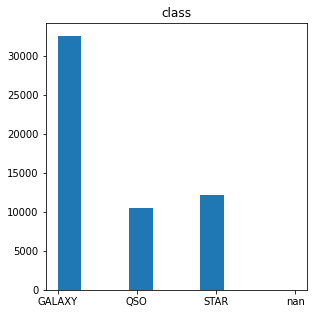

In [ ]:
#distribución categóricas:
fig , ax = plt.subplots(nrows=num_categorial_variables, ncols=1, figsize=(5,5))
plt.subplot(1,num_categorial_variables, 1)
plt.hist(df_ok['class'])
plt.title('class')

plt.tight_layout(pad=3.0)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribución del target')

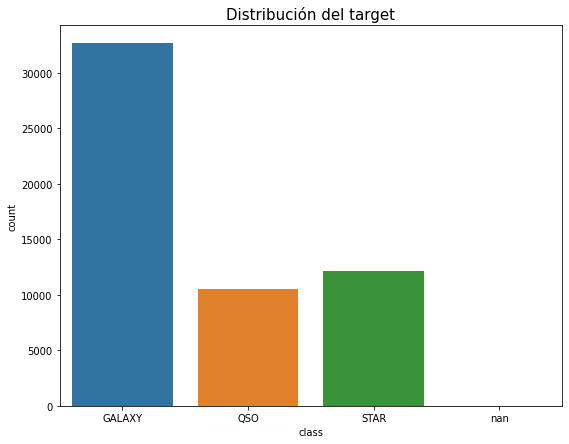

In [ ]:
# distribución de variables categoricas (target o label)

plt.figure(figsize=(9,7))
sns.countplot(df_ok['class'])
plt.title('Distribución del target', {'fontsize': 15})

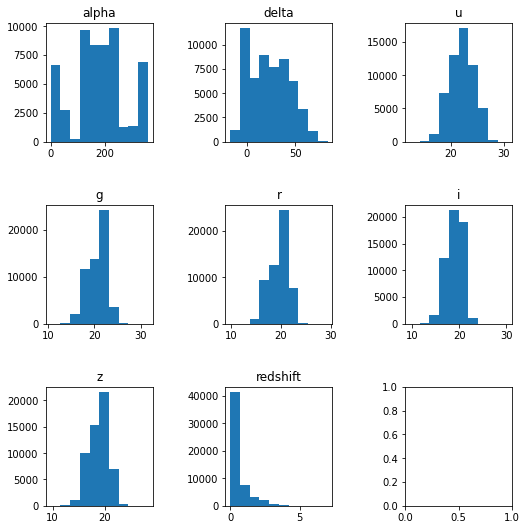

In [ ]:
# Distribución variables continuas:
fig , ax = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
plt.subplot(3,3,1)
plt.hist(df_ok['alpha'])
plt.title('alpha')
plt.subplot(3,3,2)
plt.hist(df_ok['delta'])
plt.title('delta')
plt.subplot(3,3,3)
plt.hist(df['u'])
plt.title('u')
plt.subplot(3,3,4)
plt.hist(df_ok['g'])
plt.title('g')
plt.subplot(3,3,5)
plt.hist(df_ok['r'])
plt.title('r')
plt.subplot(3,3,6)
plt.hist(df_ok['i'])
plt.title('i')
plt.subplot(3,3,7)
plt.hist(df_ok['z'])
plt.title('z')
plt.subplot(3,3,8)
plt.hist(df_ok['redshift'])
plt.title('redshift')

plt.tight_layout(pad=3.0)
plt.show()


In [ ]:
# por si acaso guardamos df_ok por si lo necesitamos

df_ok_old = df_ok
df_ok_old

,alpha,delta,u,g,r,i,z,redshift,class
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,GALAXY
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,GALAXY
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,GALAXY
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,GALAXY
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,GALAXY
...,...,...,...,...,...,...,...,...,...
55340,356.061071,2.879792,22.19557,21.62727,21.65413,21.12298,21.59212,1.752453,QSO
55341,331.044987,43.717188,19.83978,18.46996,17.84283,17.57303,17.40073,-0.000217,STAR
55342,116.853046,42.067044,21.81614,22.34572,21.56032,22.17046,21.28480,1.309830,QSO
55343,134.587935,33.275290,18.57216,17.06210,16.28253,15.78594,15.53750,0.073666,QSO


In [ ]:
# encontrar los NaN
missing_values = df_ok.isnull()
missing_values

,alpha,delta,u,g,r,i,z,redshift,class
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
55340,False,False,False,False,False,False,False,False,False
55341,False,False,False,False,False,False,False,False,False
55342,False,False,False,False,False,False,False,False,False
55343,False,False,False,False,False,False,False,False,False


In [ ]:
df_ok.isnull().sum()

alpha       0
delta       0
u           0
g           0
r           1
i           1
z           1
redshift    1
class       0
dtype: int64

In [ ]:
df_ok.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55345 entries, 0 to 55344
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   alpha     55345 non-null  float64
 1   delta     55345 non-null  float64
 2   u         55345 non-null  float64
 3   g         55345 non-null  float64
 4   r         55344 non-null  float64
 5   i         55344 non-null  float64
 6   z         55344 non-null  float64
 7   redshift  55344 non-null  float64
 8   class     55345 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.8+ MB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


In [ ]:
# borramos los NaN
# eliminamos los valores nulos NaN

df_ok = df_ok.dropna()
df_ok

,alpha,delta,u,g,r,i,z,redshift,class
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,GALAXY
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,GALAXY
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,GALAXY
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,GALAXY
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,GALAXY
...,...,...,...,...,...,...,...,...,...
55339,135.656461,1.891149,22.85328,21.25367,20.92643,20.71095,20.45398,0.000777,STAR
55340,356.061071,2.879792,22.19557,21.62727,21.65413,21.12298,21.59212,1.752453,QSO
55341,331.044987,43.717188,19.83978,18.46996,17.84283,17.57303,17.40073,-0.000217,STAR
55342,116.853046,42.067044,21.81614,22.34572,21.56032,22.17046,21.28480,1.309830,QSO


In [ ]:
df_ok.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55344 entries, 0 to 55343
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   alpha     55344 non-null  float64
 1   delta     55344 non-null  float64
 2   u         55344 non-null  float64
 3   g         55344 non-null  float64
 4   r         55344 non-null  float64
 5   i         55344 non-null  float64
 6   z         55344 non-null  float64
 7   redshift  55344 non-null  float64
 8   class     55344 non-null  object 
dtypes: float64(8), object(1)
memory usage: 4.2+ MB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


Correlación entre variables (matriz de correlación):

In [ ]:
#todas las correlaciones entre las variables
df_ok.corr()

,alpha,delta,u,g,r,i,z,redshift
alpha,1.000000,0.091517,0.020833,0.005650,-0.006179,-0.012302,-0.016657,0.003837
delta,0.091517,1.000000,0.001751,0.020258,0.010680,0.003792,-0.002446,0.028958
u,0.020833,0.001751,1.000000,0.854264,0.728568,0.616678,0.543274,0.164828
g,0.005650,0.020258,0.854264,1.000000,0.932870,0.846787,0.773706,0.319305
r,-0.006179,0.010680,0.728568,0.932870,1.000000,0.963844,0.919450,0.433337
i,-0.012302,0.003792,0.616678,0.846787,0.963844,1.000000,0.971610,0.489601
z,-0.016657,-0.002446,0.543274,0.773706,0.919450,0.971610,1.000000,0.496988
redshift,0.003837,0.028958,0.164828,0.319305,0.433337,0.489601,0.496988,1.000000


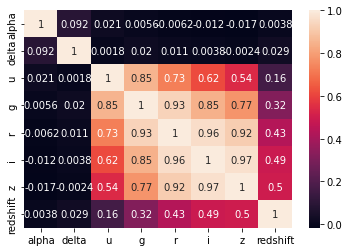

In [ ]:
# mapa de calor de correlación
sns.heatmap(df_ok.corr(),annot=True)  # 'annot' para poner o no los números
plt.show()

Ordenamos según el coeficiente de correlación atendiendo a su valor absoluto. La clase es la variable a predecir (target). La correlación se mira con el target

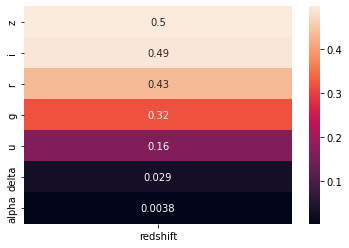

In [ ]:
corr_redshift = df_ok.corr()['redshift'].reindex(df_ok.corr()['redshift'].abs()[:-1].sort_values(ascending=False).index)
sns.heatmap(corr_redshift.to_frame(), annot=True)
plt.show()

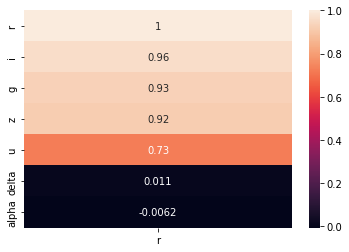

In [ ]:
corr_r = df_ok.corr()['r'].reindex(df_ok.corr()['r'].abs()[:-1].sort_values(ascending=False).index)
sns.heatmap(corr_r.to_frame(), annot=True)
plt.show()

### Comparativa gráfica entre features

In [ ]:
galaxy = df_ok[df_ok['class']=='GALAXY']
galaxy

,alpha,delta,u,g,r,i,z,redshift,class
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,GALAXY
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,GALAXY
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,GALAXY
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,GALAXY
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,GALAXY
...,...,...,...,...,...,...,...,...,...
55331,127.811732,19.404912,24.05407,21.44381,19.86267,19.07149,18.56782,0.454845,GALAXY
55332,177.003744,35.902543,26.13058,24.28005,21.54930,20.39901,19.70619,0.757231,GALAXY
55333,127.701799,29.414404,20.00029,18.13531,17.06027,16.58685,16.24159,0.135118,GALAXY
55334,233.697391,37.312588,25.04108,22.11564,20.41724,19.38720,19.18046,0.584835,GALAXY


In [ ]:
star = df_ok[df_ok['class']=='STAR']
star

,alpha,delta,u,g,r,i,z,redshift,class
9,39.149691,28.102842,21.74669,20.03493,19.17553,18.81823,18.65422,-0.000008,STAR
12,345.801874,32.672868,23.17274,20.14496,19.41948,19.22034,18.89359,0.000072,STAR
16,353.201522,3.080796,24.54890,21.44267,20.95315,20.79360,20.48442,-0.000429,STAR
18,14.383135,3.214326,21.82154,20.55730,19.94918,19.76057,19.55514,-0.000440,STAR
21,144.785293,46.826496,24.54793,22.33601,20.92259,19.87177,19.16934,-0.000120,STAR
...,...,...,...,...,...,...,...,...,...
55326,238.195762,12.359286,24.05235,21.60999,20.55672,20.13893,20.29883,-0.000136,STAR
55335,128.041087,33.098899,21.17015,18.62299,17.65439,17.30801,17.08446,0.000122,STAR
55337,319.225923,8.693267,21.72821,19.68781,19.00372,18.46772,18.21941,0.000042,STAR
55339,135.656461,1.891149,22.85328,21.25367,20.92643,20.71095,20.45398,0.000777,STAR


In [ ]:
qso = df_ok[df_ok['class']=='QSO']
qso

,alpha,delta,u,g,r,i,z,redshift,class
5,340.995121,20.589476,23.48827,23.33776,21.32195,20.25615,19.54544,1.424659,QSO
6,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,0.586455,QSO
17,1.494389,3.291746,20.38562,20.40514,20.29996,20.05918,19.89044,2.031528,QSO
23,145.883006,47.300484,21.73992,21.53095,21.26763,21.36257,21.15861,2.075680,QSO
33,20.052556,11.497881,21.89214,21.35124,21.18755,20.84300,20.76580,1.528308,QSO
...,...,...,...,...,...,...,...,...,...
55327,123.507875,57.789002,23.10765,23.73477,21.64650,20.41353,19.34155,1.178463,QSO
55338,344.663428,3.047274,22.15038,21.74470,21.53734,21.13085,21.49230,0.836476,QSO
55340,356.061071,2.879792,22.19557,21.62727,21.65413,21.12298,21.59212,1.752453,QSO
55342,116.853046,42.067044,21.81614,22.34572,21.56032,22.17046,21.28480,1.309830,QSO


Text(0.5, 1.0, 'alpha vs redshift para galaxia')

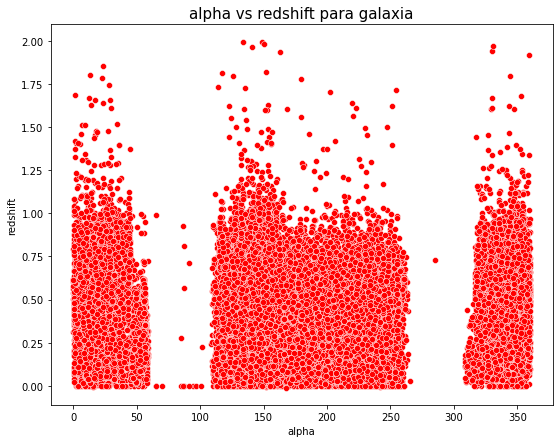

In [ ]:
# alpha vs redshift para galaxias. Vemos que no hay correlación
plt.figure(figsize=(9,7))
sns.scatterplot(x='alpha', y='redshift', data=galaxy, color='r')
plt.title('alpha vs redshift para galaxia', {'fontsize': 15})

Text(0.5, 1.0, 'alpha vs redshift para estrellas')

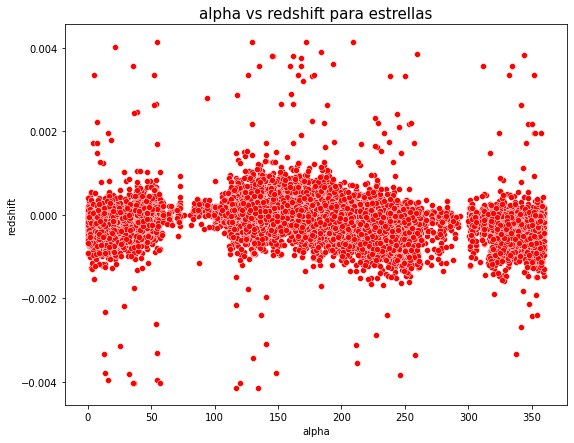

In [ ]:
# alpha vs redshift para estrellas
plt.figure(figsize=(9,7))
sns.scatterplot(x='alpha', y='redshift', data=star, color='r')
plt.title('alpha vs redshift para estrellas', {'fontsize': 15})

Text(0.5, 1.0, 'alpha vs redshift para cuásars')

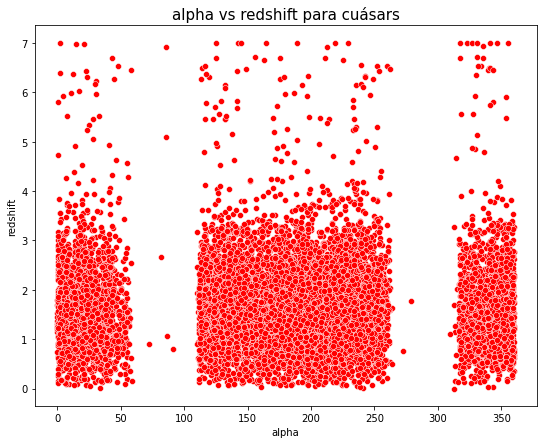

In [ ]:
# alpha vs redshift para cuasars
plt.figure(figsize=(9,7))
sns.scatterplot(x='alpha', y='redshift', data=qso, color='r')
plt.title('alpha vs redshift para cuásars', {'fontsize': 15})

Text(0.5, 1.0, 'g vs r para galaxia')

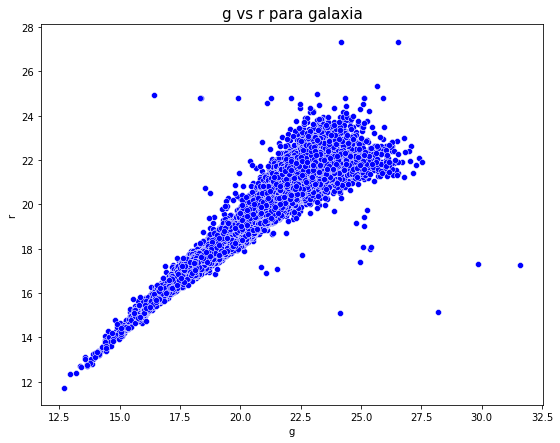

In [ ]:
# g vs r para galaxias. Vemos que hay alta correlación lineal positiva
plt.figure(figsize=(9,7))
sns.scatterplot(x='g', y='r', data=galaxy, color='b')
plt.title('g vs r para galaxia', {'fontsize': 15})
# se aprecia que está muy correlacionado

Text(0.5, 1.0, 'g vs r para estrellas')

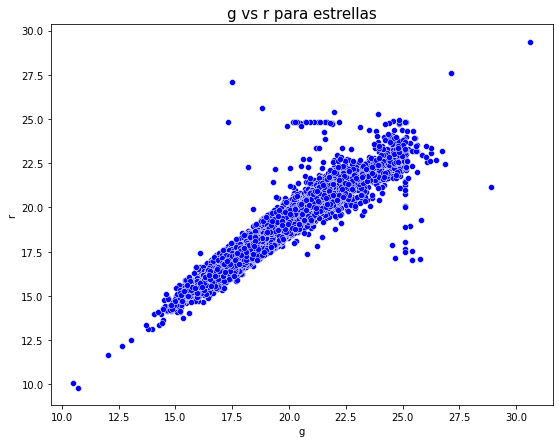

In [ ]:
# g vs r para estrellas
plt.figure(figsize=(9,7))
sns.scatterplot(x='g', y='r', data=star, color='b')
plt.title('g vs r para estrellas', {'fontsize': 15})
# se aprecia que está muy correlacionado lineal positiva

Text(0.5, 1.0, 'g vs r para cuásares')

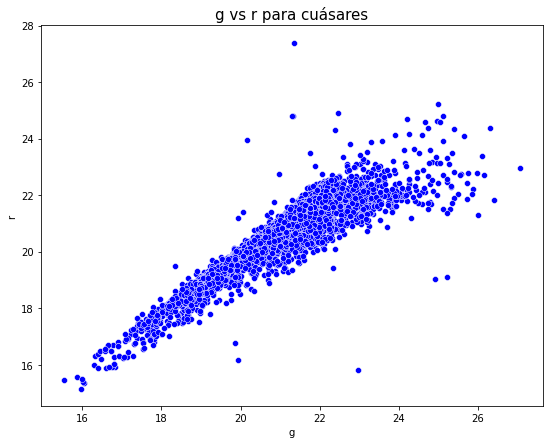

In [ ]:
# g vs r para cuásares
plt.figure(figsize=(9,7))
sns.scatterplot(x='g', y='r', data=qso, color='b')
plt.title('g vs r para cuásares', {'fontsize': 15})
# se aprecia que está muy correlacionado

# Red neuronal de clasificación
### clasificar las observaciones según la clase a la que pertenece: galaxia, quasar, estrella 

### PREPROCESADO

In [ ]:
# Crear el vector de características y el vector a predecir
# Quitamos las variables que creemos que no influyen (con drop) y la variable target (class)

features = df_ok.drop(columns=["class"])
features

,alpha,delta,u,g,r,i,z,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123
...,...,...,...,...,...,...,...,...
55339,135.656461,1.891149,22.85328,21.25367,20.92643,20.71095,20.45398,0.000777
55340,356.061071,2.879792,22.19557,21.62727,21.65413,21.12298,21.59212,1.752453
55341,331.044987,43.717188,19.83978,18.46996,17.84283,17.57303,17.40073,-0.000217
55342,116.853046,42.067044,21.81614,22.34572,21.56032,22.17046,21.28480,1.309830


In [ ]:
labels = df_ok["class"].to_frame()
labels

,class
0,GALAXY
1,GALAXY
2,GALAXY
3,GALAXY
4,GALAXY
...,...
55339,STAR
55340,QSO
55341,STAR
55342,QSO


In [ ]:
list(features.columns)

['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']

### Normalizar con StandarScaler()

In [ ]:
# porque podemos tener números muy distintos. Homogeneizamos los valores (mismo orden de magnitud)
# recordar que sólo podemos normalizar valores numéricos no categóricos

features_scaler = StandardScaler().fit_transform(features)


print(features_scaler)

[[-0.45551207  0.44995269  0.80743567 ...  0.04363671  0.0093357
   0.08071794]
 [-0.3603703   0.38803525  1.20896569 ...  1.18672802  1.60868871
   0.27746877]
 [-0.38783211  0.60660794  1.42585633 ...  0.14801339  0.09697646
   0.09353216]
 ...
 [ 1.57869122  1.01931124 -0.99702579 ... -0.86557755 -0.78053111
  -0.78485532]
 [-0.65164835  0.93559379 -0.11407701 ...  1.75892732  1.42186807
   1.00084931]
 [-0.46697835  0.48955815 -1.56334141 ... -1.88576195 -1.8370456
  -0.68414547]]


In [ ]:
# Codificamos las labels que son categorias con un método de codificación
# existen dos métodos: LabelEnconder y OneHotEnconder


print(labels)
labels_encoders = OneHotEncoder().fit_transform(labels).toarray()
print(labels_encoders)


        class
0      GALAXY
1      GALAXY
2      GALAXY
3      GALAXY
4      GALAXY
...       ...
55339    STAR
55340     QSO
55341    STAR
55342     QSO
55343     QSO

[55344 rows x 1 columns]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [ ]:
# cambio de nomenclatura por comodidad

X = features_scaler
y = labels_encoders
print(X)
print('..................')
print(y)

[[-0.45551207  0.44995269  0.80743567 ...  0.04363671  0.0093357
   0.08071794]
 [-0.3603703   0.38803525  1.20896569 ...  1.18672802  1.60868871
   0.27746877]
 [-0.38783211  0.60660794  1.42585633 ...  0.14801339  0.09697646
   0.09353216]
 ...
 [ 1.57869122  1.01931124 -0.99702579 ... -0.86557755 -0.78053111
  -0.78485532]
 [-0.65164835  0.93559379 -0.11407701 ...  1.75892732  1.42186807
   1.00084931]
 [-0.46697835  0.48955815 -1.56334141 ... -1.88576195 -1.8370456
  -0.68414547]]
..................
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


### Dividimos el conjunto de datos en entrenamiento y test

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.2)

In [ ]:
print("dimension del conjunto de entrenamiento features: " + str(train_X.shape))
print("dimension del conjunto de entrenamiento labels: " + str(train_Y.shape))
print("dimension del conjunto de prueba features: " + str(test_X.shape))
print("dimension del conjunto de prueba labels: " + str(test_Y.shape))

dimension del conjunto de entrenamiento features: (44275, 8)
dimension del conjunto de entrenamiento labels: (44275, 3)
dimension del conjunto de prueba features: (11069, 8)
dimension del conjunto de prueba labels: (11069, 3)


In [ ]:
44275 + 11069

55344

In [ ]:
0.2*55344

11068.800000000001

### BÚSQUEDA DE HIPERPARÁMETROS


In [ ]:
# creamos tres capas ocultas

numero_inputs = train_X.shape[1]
numero_ouputs = train_Y.shape[1]
print(numero_inputs)
print(numero_ouputs)

8
3


In [ ]:
# creamos el modelo
# utilizamos regularización para evitar overfitting. En este cado Dropout
# https://www.iartificial.net/regularizacion-lasso-l1-ridge-l2-y-elasticnet/
modelo = tf.keras.Sequential([tf.keras.layers.Input(shape=(numero_inputs,), name='Entrada'), 
                              tf.keras.layers.Dense(128, activation='relu',kernel_initializer='normal', name='Oculta1'),
                              tf.keras.layers.Dense(32, activation='tanh', kernel_initializer='normal', name='Oculta2'), 
                              tf.keras.layers.Dropout(0.25),    # con esto estamos quitando (podando) el 25% del número de neuronas al azar                   
                              tf.keras.layers.Dense(16, activation='tanh', kernel_initializer='normal', name='Oculta3'),                              
                              tf.keras.layers.Dense(numero_ouputs, name='Salida')]) 

In [ ]:
# estudiamos ahora como mejorarlo, cambiando tasa de aprendizaje y la función de activación
# vemos la influencia de los hiperparámetros para la optimización

In [ ]:
import timeit
def arq_train(optimizador, velocidad_aprendizaje):
  start = timeit.default_timer()
  modelo.compile(loss='binary_crossentropy', optimizer=optimizador(learning_rate=velocidad_aprendizaje), metrics=['accuracy'])
  histor = modelo.fit(train_X, train_Y, epochs=50, validation_data = (test_X, test_Y), batch_size=64, verbose=0)
  end = timeit.default_timer()
  time = end - start
  accuracy = histor.history['accuracy'][19]
  return [time, accuracy]

In [ ]:
# queremos crear una función que parametrice esto, poniendo el optimizador y la tasa de aprendizaje dinámica:

#lr = [0.001, 0.01, 0.05, 0.1]
lr = [0.01, 0.1]
# opt_keras = [Adam, SGD, Adadelta, Adagrad]
# opt_str = ['Adam', 'SGD', 'Adadelta', 'Adagrad']
opt_keras = [SGD, Adadelta, Adagrad]
opt_str = ['SGD', 'Adadelta', 'Adagrad']
opt = zip(opt_keras, opt_str)
dic = {}

In [ ]:
for i_1, i_2 in opt: 
  opt_result = []
  for j in lr:
    opt_result += [arq_train(i_1, j)]
  dic[str(i_2)] = opt_result

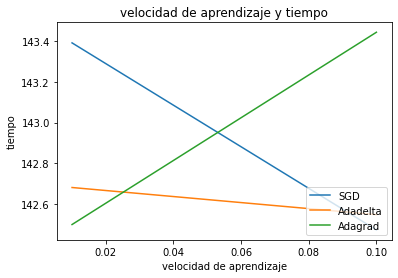

In [ ]:
for i in opt_str: 
  plt.plot(lr, [i[0] for i in dic[i]])
plt.legend(opt_str, loc = 'lower right')
plt.title('velocidad de aprendizaje y tiempo')
plt.xlabel('velocidad de aprendizaje')
plt.ylabel('tiempo')
plt.show()

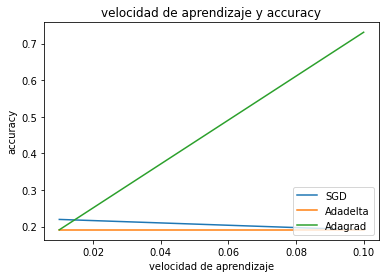

In [ ]:
for i in opt_str: 
  plt.plot(lr, [i[1] for i in dic[i]])
plt.legend(opt_str, loc = 'lower right')
plt.title('velocidad de aprendizaje y accuracy')
plt.xlabel('velocidad de aprendizaje')
plt.ylabel('accuracy')
plt.show()

# Conclusión
el mejor  accuracy es adagrad, aunque tiempo sea peor, pero esto no nos importa aunque tarde más en procesar. A un lr=0.1 (tasa de aprendizaje)


### Modelo base de la red neuronal

In [ ]:
# creamos tres capas ocultas

numero_inputs = train_X.shape[1]
numero_ouputs = train_Y.shape[1]
print(numero_inputs)
print(numero_ouputs)

8
3


In [ ]:
# creamos el modelo
# utilizamos regularización para evitar overfitting. En este cado Dropout
# https://www.iartificial.net/regularizacion-lasso-l1-ridge-l2-y-elasticnet/
modelo_2 = tf.keras.Sequential([tf.keras.layers.Input(shape=(numero_inputs,), name='Entrada'), 
                              tf.keras.layers.Dense(128, activation='relu',kernel_initializer='normal', name='Oculta1'),
                              tf.keras.layers.Dense(32, activation='tanh', kernel_initializer='normal', name='Oculta2'), 
                              tf.keras.layers.Dropout(0.25),    # con esto estamos quitando (podando) el 25% del número de neuronas al azar                   
                              tf.keras.layers.Dense(16, activation='tanh', kernel_initializer='normal', name='Oculta3'),                              
                              tf.keras.layers.Dense(numero_ouputs, name='Salida')]) 

In [ ]:
seed = 7
np.random.seed(seed)

In [ ]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Oculta1 (Dense)             (None, 128)               1152      
                                                                 
 Oculta2 (Dense)             (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 Oculta3 (Dense)             (None, 16)                528       
                                                                 
 Salida (Dense)              (None, 3)                 51        
                                                                 
Total params: 5,859
Trainable params: 5,859
Non-trainable params: 0
_________________________________________________________________


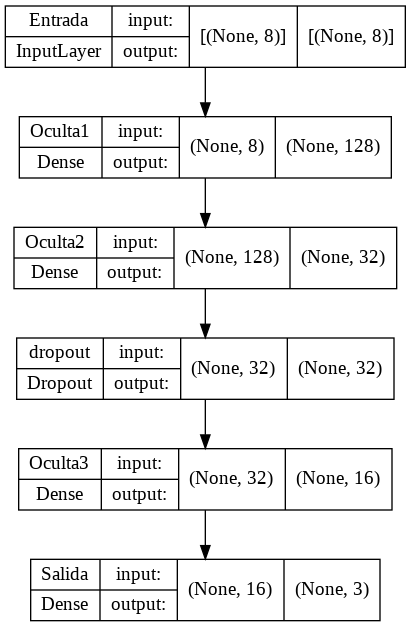

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(modelo, to_file='modelo_plot.png', show_shapes=True, show_layer_names=True)

### Compilado

In [ ]:
# escogiendo el adagrad que como hemos visto arriba es el mejor optimizador con lr=0.1, lo compilamos con esos datos
# se requiere elegir un algoritmo de optimización. sgd es el descenso de gradiente estocástico
# también se requiere una función de pérdida como parámetro. 
# una métrica que nos valore la performance del modelo. Nos dice cuán bueno es el modelo (existen varias, accuracy es bueno para problemas de clasificación, mae es para predicción, r_square es para regresión)
modelo_2.compile(optimizer=Adagrad(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


### Entrenamiento

In [ ]:
history = modelo_2.fit(train_X, train_Y,
                    epochs=100, #número de iteracciones
                    batch_size=32, # grupo de datos que lee cada vez
                    validation_data = (test_X, test_Y),  # este es otro método de validación del modelo. Ahora usamos los de test para validar                   
                    verbose=1 # nos da toda la información cuando compila
                     )

Epoch 1/100
1384/1384 [==============================] - 11s 7ms/step - loss: 2.1985 - accuracy: 0.6967 - val_loss: 1.5405 - val_accuracy: 0.7497
Epoch 2/100
1384/1384 [==============================] - 6s 4ms/step - loss: 1.1858 - accuracy: 0.7579 - val_loss: 0.6678 - val_accuracy: 0.7847
Epoch 3/100
1384/1384 [==============================] - 6s 4ms/step - loss: 0.5968 - accuracy: 0.8245 - val_loss: 0.2931 - val_accuracy: 0.8976
Epoch 4/100
1384/1384 [==============================] - 6s 4ms/step - loss: 0.3565 - accuracy: 0.8824 - val_loss: 0.3198 - val_accuracy: 0.8974
Epoch 5/100
1384/1384 [==============================] - 6s 5ms/step - loss: 0.8699 - accuracy: 0.8168 - val_loss: 1.3503 - val_accuracy: 0.7537
Epoch 6/100
1384/1384 [==============================] - 6s 4ms/step - loss: 1.3900 - accuracy: 0.7490 - val_loss: 1.3501 - val_accuracy: 0.7539
Epoch 7/100
1384/1384 [==============================] - 6s 4ms/step - loss: 1.3778 - accuracy: 0.7506 - val_loss: 1.3378 - val_a

### Hemos entrenado el modelo. Esto es obtener los pesos (los parámetros) que minimizan nuestra función de error.

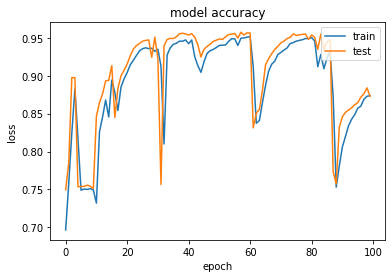

In [ ]:
# representamos la evolución de los errores durante el entrenamiento
# Plots
# visualizamos la evolución del error cometido por la red

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

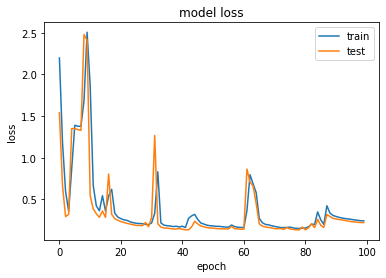

In [ ]:
# Plots
# visualizamos la evolución del error cometido por la red

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
results = modelo.evaluate(test_X, test_Y, verbose=1)
print('Test Loss: {}'.format(results))

346/346 [==============================] - 1s 3ms/step - loss: 2.3912 - accuracy: 0.7546
Test Loss: [2.3912160396575928, 0.7546300292015076]


### Usaremos ahora la función predict para generar unas predicciones 

In [ ]:
y_pred = modelo_2.predict(test_X)
y_pred

array([[ 1.1263485 , -0.1980962 , -0.35272852],
       [ 0.6775372 ,  0.03180704,  0.31964606],
       [ 0.08165856, -1.1163074 ,  0.97605556],
       ...,
       [ 1.0974209 , -0.4017207 , -0.3425008 ],
       [ 0.64708996,  0.07628915,  0.326405  ],
       [ 0.64286155,  0.28318903, -0.15922096]], dtype=float32)

In [ ]:
y_true = test_Y
y_true

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [ ]:
umbral = 0.5
y_pred_binario = (y_pred > umbral)
y_pred_binario

array([[ True, False, False],
       [ True, False, False],
       [False, False,  True],
       ...,
       [ True, False, False],
       [ True, False, False],
       [ True, False, False]])

In [ ]:
# REPORT
# es el equivalente a más dimensiones de la matriz de confusión

from sklearn.metrics import classification_report

In [ ]:
# el primer parámetro es el valor verdadero, el segundo el valor predicho
print(classification_report(y_true, y_pred_binario))

              precision    recall  f1-score   support

           0       0.86      0.96      0.90      6553
           1       0.97      0.89      0.93      2102
           2       0.87      0.58      0.69      2414

   micro avg       0.88      0.86      0.87     11069
   macro avg       0.90      0.81      0.84     11069
weighted avg       0.88      0.86      0.86     11069
 samples avg       0.86      0.86      0.86     11069



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
TARGET_NAMES = ['GALAXY', 'STAR', 'QSO']
print(classification_report(y_true, y_pred_binario, target_names=TARGET_NAMES))